# Importing data and packages
#### Importing function to clean.. will need to rerun things once we get Undrafted Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [94]:
df = pd.read_csv('data/final/final_df.csv')
df = df.drop(columns='Unnamed: 0')
df.shape

(9887, 149)

As of right now, I don't have the year undrafted players played their first game. As this information is key in predicting their number of seasons left, I have to drop them from the dataframe. Also, players who are currently playing in the NBA will be dropped for the purposes of modeling, as they have no year of retirement to calculate a number of seasons left.

We're going to lose a third of our entries. It's not ideal, but it's necessary for now.

In [95]:
current_players = list(df[df.current_year == 2019].Player)
cp_df = df[df.Player.isin(current_players)]

df = df[~df.Player.isin(current_players)]
df = df[df.drafted == 1]
df.shape

(6017, 149)

Creating the target variable of "seasons_left" by creating a variable "season" to track each player's current year in the NBA, and then taking the max value from that column and subtracting their current season from that max value.

In [10]:
df['season'] = df.current_year - df.draft_year

# Will move this over to the Cleaning notebook upon retrieval of the undrafteds' first years.

def compute_seasons_left():
    """This is a function that computes 
    
    """
    # Creating a 'seasons left' column with a placeholder value of -1.
    df['seasons_left'] = -1
    
    for player in df.Player.unique():
        # Creating a subsetted dataframe for each player
        temp_df = df[df.Player == player]
        # Gets the amount of seasons each player has played
        max_value = temp_df.season.max()
        # Appends the number of seasons left from the temp_df into main df
        for row in temp_df.index:
            df.loc[row, 'seasons_left'] = max_value - df.loc[row, 'season']
            

# Running the function to add the 'seasons_left' column
compute_seasons_left()

df.shape

(6017, 151)

# Running a Baseline Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
# Dropping our target variable and categorical variables our X data.
X = df.drop(columns = ['seasons_left', 'Player', 'Pos', 'Tm'])
# Setting our target variable to y.
y = df[['seasons_left']]

# Splitting our data into training and test sets, and printing their shapes to visualize
# the split. 
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=98)
print ("X_train: ", X_train.shape)
print ("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print ("y_test: ", y_test.shape)

# # Pickling Example
# import pickle

# # saves the train test split as a tuple, in the form (X_train, X_test), (y_train, y_test)
# tts_tup = tts(X,y, stratify = y, train_size = .8, random_state=98)

# # file is over 3gig or just too big, do protocol =4 
# pickle.dump(tts_tup, open(f'file path', 'wb'), )

# # Reads in the data from the saved tuples
# X_train, X_test, y_train, y_test = pickle.load(open(f'file path', 'rb'))

X_train:  (4813, 147)
y_train:  (4813, 1)
X_test:  (1204, 147)
y_test:  (1204, 1)


In [240]:
# Instantiating model
lr = LinearRegression()

# Fitting model to train data
model_lr = lr.fit(X_train, y_train)

# Predicting based on train and test data
train_pred = model_lr.predict(X_train)
test_pred = model_lr.predict(X_test)

In [241]:
print(f'Train Set R^2: {r2_score(y_train, train_pred)}')
print(f'Train Set RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
print('\n')
print(f'Test Set R^2: {r2_score(y_test, test_pred)}')
print(f'Test Set RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')

Train Set R^2: 0.5516284044728511
Train Set RMSE: 2.4975442486141106


Test Set R^2: 0.5188735128531536
Test Set RMSE: 2.5738577811170913


Using all of our production variables and descriptive data about each player (Age, Height,
Weight), the r^2 value from our base model states that 55% of the variance in our target variable of seasons left can be explained by the aforementioned variables (in both the training and test set).

Also, from looking at the RMSE, on average the baseline model predicts number of seasons left
for a given player within 2.5 years. 

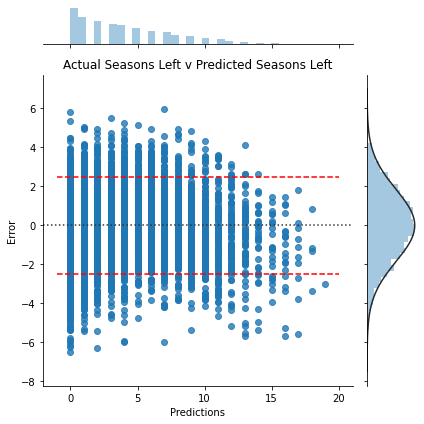

In [242]:
# Doing a jointplot with the residuals of our data to see how far off our estimations are.
sns.jointplot(y_train, train_pred, kind = 'resid')


#Plotting lines that indicate where our RMSE lies.
plt.hlines(np.sqrt(mean_squared_error(y_train, train_pred)), xmin=-1, xmax=20,
          linestyles='dashed', color='red')
plt.hlines(-(np.sqrt(mean_squared_error(y_train, train_pred))), xmin=-1, xmax=20,
          linestyles='dashed', color='red')

plt.xlabel('Predictions')
plt.ylabel('Error')
plt.title('Actual Seasons Left v Predicted Seasons Left')
plt.tight_layout()
plt.show()

The above plot visualizes the amount of error in our model, and that it tends to predict best when players have 4-10 years left in their careers. 

The next step is going to be checking for collinearity between features, and seeing if any of the features are strongly correlated with our target variable. 

## Checking for collinearity between our predictor variables
I ran a correlation matrix using all of the features, and it was a bit of a mess; however, there are a couple trends that can be gleaned from it. Regular season features are inneficient at predicting playoff features (and vice versa), and there seem to be correlations between features within each of those subsets.

Seeing this, I will create two smaller correlation matrices that will hopefully be less cluttered, and give us some useful information relating to predicting seasons_left.


In [157]:
# Code for the correlation matrix using all of the features.

# Code from: https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices/notebook

# features = list(df.columns)

# mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
# mask[np.triu_indices_from(mask)] = True 

# f, ax = plt.subplots(figsize=(20, 16))
# plt.title('Pearson Correlation Matrix',fontsize=25)

# sns.heatmap(df[features].corr(),linewidths=0.25,square=True,cmap="BuGn", #"BuGn_r" to reverse 
#             linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

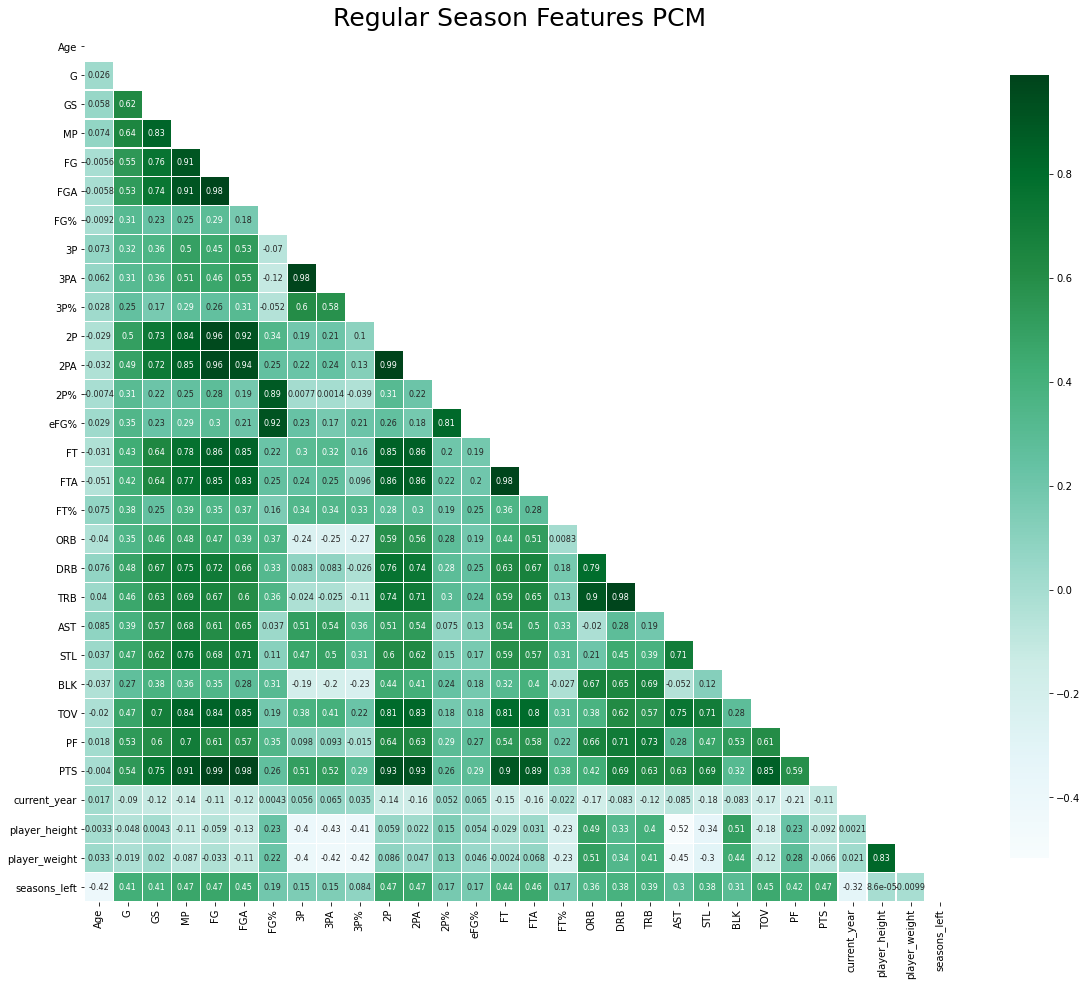

In [155]:
# Code from: https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices/notebook

features = list(df.columns)[:30] + ['player_height', 'player_weight', 'seasons_left']

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(20, 16))
plt.title('Regular Season Features PCM',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});


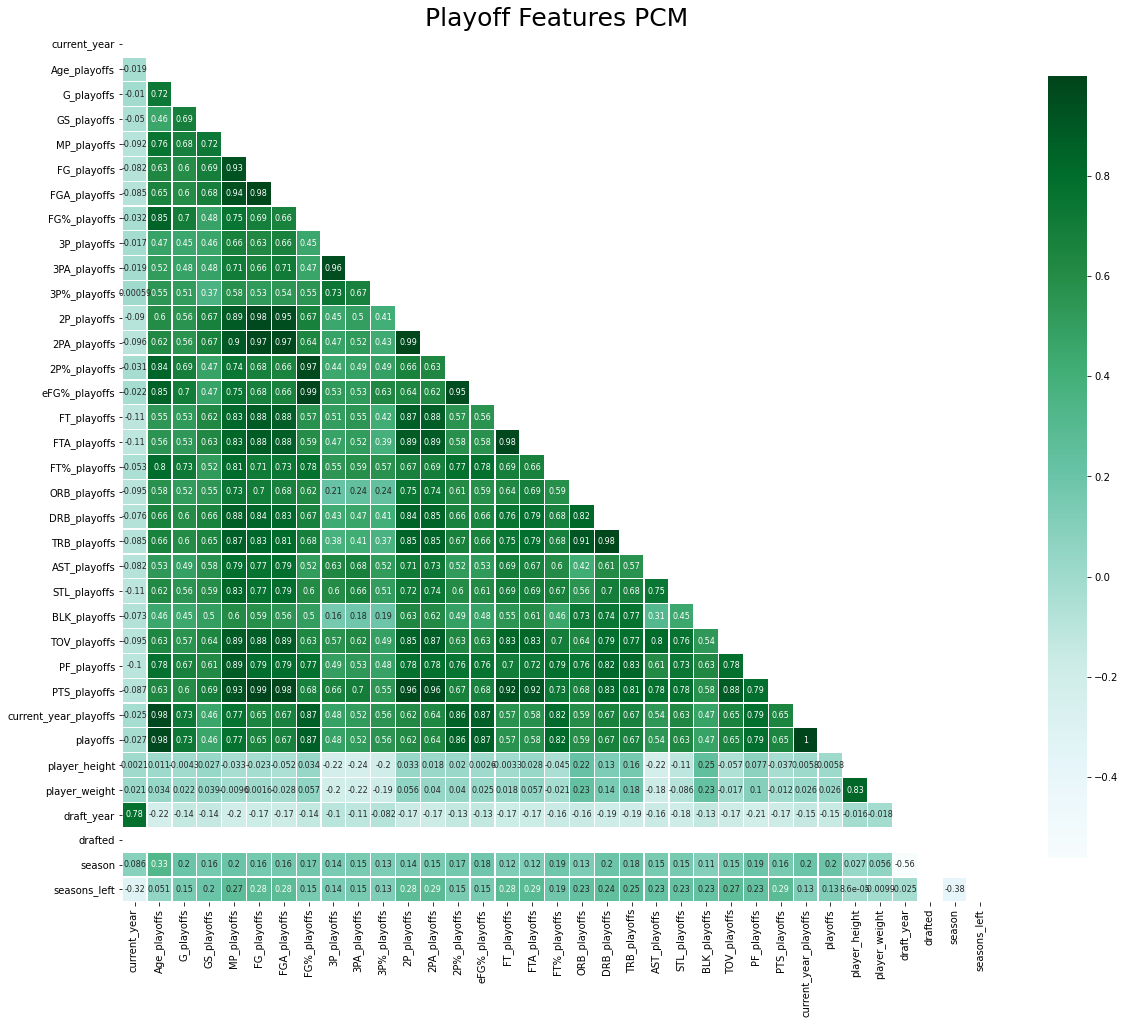

In [156]:
# Code from: https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices/notebook

features = list(df.columns)[29:]

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(20, 16))
plt.title('Playoff Features PCM',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});


# Throwing the Kitchen Sink (of models) at our data
We have a baseline RMSE = 2.56 from our vanilla linear regression model, and are now going to try a few other models that can predict our quantitative target variable. After looking at the results, we will tune the most promising models based off of their RMSE.

The models to be ran are:
1. KNN Regressor
2. Decision Tree Classifier
3. Random Forest Regressor
4. Extra Trees Regressor
5. AdaBoost
6. XGBoost
7. Naive Bayes Gaussian

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
import xgboost as xgb 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

# Models to be ran, in the format {'Abbreviation' : Instantiated Model}
models = {'KNN': KNeighborsRegressor(),
          'DT': DecisionTreeRegressor(),
          'RF': RandomForestRegressor(),
          'ET': ExtraTreesRegressor(),
          'ADA': AdaBoostRegressor(),
          'Gaussian': GaussianNB(),
          }

# Dropping our target variable and categorical variables our X data.
X = df.drop(columns = ['seasons_left', 'Player', 'Pos', 'Tm'])
# Setting our target variable to y.
y = df[['seasons_left']]
# Splitting our data into train and test sets
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=98)

# Flattening the target variables to a 1d array for our models
y_train = y_train.seasons_left.values.ravel()
y_test = y_test.seasons_left.values.ravel()
y = y.seasons_left.values.ravel()

# Testing each model
results = []
model_names = []
pbar = tqdm(models.items())

for model, m in pbar: 
    # Fitting our models to the training data
    m.fit(X_train, y_train)
    # Setting a progress bar to track the progress of each model
    pbar.set_description(f'Evaluating {model.upper()}')
    # Predicting target variables
    train_pred = m.predict(X_train)
    # Saving our R^2 values
    scores = m.score(X_train, y_train)
    # Saving our Root Squared Mean Errors
    rmses = np.sqrt(mean_squared_error(y_train, train_pred))
    
    results.append((scores, rmses))
    model_names.append(model)   
    
# Printing out the results of our models
vanilla_dict = {i:y for i,y in zip(model_names, results)}
vanilla_dict

Evaluating GAUSSIAN: 100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


{'KNN': (0.43907143604076204, 2.7934951599760245),
 'DT': (1.0, 0.0),
 'RF': (0.9452199271421705, 0.8729823194454793),
 'ET': (1.0, 0.0),
 'ADA': (0.4702882648245428, 2.7146506156895702),
 'Gaussian': (0.21774361105339704, 4.1363374314445345)}

In [194]:
# Will get around to checking out XGBoost at a later time

# # Fitting and testing the XGBoost model

# train_set, test_set = tts(df, test_size=0.2, random_state=98)

# # Specify parameters via map
# param = 
# bst = xgb.train(dtrain = train_set)

Looking at our results, we'll go ahead and try hypertuning on the RandomForestRegressor, KNNRegressor, and the AdaBoostRegressor. The RF is likely overfitting in its current state, but with some hypertuning I believe it will end up in a better place.

In [18]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [33]:
# RandomForest Tuning
param_grid = {
            'n_estimators': [25, 50, 75, 100],
            'criterion': ['mse'],
            'max_depth': [None, 100, 250, 300, 350, 450],
            'min_samples_split': [5, 8, 10, 15],
            'min_samples_leaf': [3, 5, 10, 15],
            'max_features': [10, 15, 20, 25, 30],
        }

# In the interest of time, going to be using RandomizedSearchCV over GridSearch.
gs = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = param_grid,
                                verbose = 1, n_iter = 50,
                                n_jobs = 1)

gs.fit(X_train, y_train)

print(f'Random Forest\'s Best Estimators')
print(gs.best_estimator_)

RF_tuned = gs.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.5min finished


Random Forest's Best Estimators
RandomForestRegressor(max_depth=300, max_features=30, min_samples_leaf=5,
                      min_samples_split=8, n_estimators=50)


In [34]:
# Printing R^2 and RMSE for the Random Forest Regressor
train_pred = RF_tuned.predict(X_train)
test_pred = RF_tuned.predict(X_test)

print(f'Train Set R^2: {RF_tuned.score(X_train, y_train)}')
print(f'Train Set RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
print('\n')
print(f'Test Set R^2: {RF_tuned.score(X_test, test_pred)}')
print(f'Test Set RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')

Train Set R^2: 0.8430859041170221
Train Set RMSE: 1.4774919544491076


Test Set R^2: 1.0
Test Set RMSE: 2.352802294240261


Looking at the R^2 scores, the Random Forest model seems like it might still be overfitting to the training set, and is definitely overfitting to the test set.


Now to tune the KNN Regressor, and see how it performs.

In [21]:
#KNNRegressor Tuning

# Setting the parameters to be searched through.
k_range = list(range(1, 30))

param_grid = {
    'n_neighbors': k_range,
    'p': [1, 2],
}

gs = RandomizedSearchCV(estimator = KNeighborsRegressor(), param_distributions = param_grid,
                        n_jobs = 1, verbose = 1, n_iter = 50)

gs.fit(X_train, y_train)

print(f'KNN\'s Best Estimators')
print(gs.best_estimator_)

KNN_tuned = gs.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN's Best Estimators
KNeighborsRegressor(n_neighbors=20, p=1)


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   26.9s finished


In [25]:
# Printing R^2 and RMSE for the KNN Regressor
train_pred = KNN_tuned.predict(X_train)
test_pred = KNN_tuned.predict(X_test)

print(f'Train Set R^2: {KNN_tuned.score(X_train, y_train)}')
print(f'Train Set RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
print('\n')
print(f'Test Set R^2: {KNN_tuned.score(X_test, test_pred)}')
print(f'Test Set RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')

Train Set R^2: 0.3818174084719619
Train Set RMSE: 2.9325979771341615


Test Set R^2: 1.0
Test Set RMSE: 3.062268365367124


The KNN model seems to be underfitting to the training data and overfitting to the test data, as shown by the respective R^2 scores. 

How will a tuned AdaBoost model do?

In [23]:
#AdaBoost Tuning
AdaBoostRegressor()
#Setting the parameters to be searched through
param_grid = {
            'n_estimators': [25, 50, 75, 100],
            'learning_rate': [0.5, 1, 1.5, 2],
            'loss': ['linear', 'square'],
            'random_state': [98]
        }

gs = RandomizedSearchCV(estimator = AdaBoostRegressor(), param_distributions = param_grid,
                        n_jobs = 1, verbose = 1, n_iter = 50)

gs.fit(X_train, y_train)

print(f'AdaBoost\'s Best Estimators')
print(gs.best_estimator_)

ADA_tuned = gs.best_estimator_

train_pred = ADA_tuned.predict(X_train)

/Users/npardue/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  4.5min finished


AdaBoost's Best Estimators
AdaBoostRegressor(learning_rate=0.5, n_estimators=25, random_state=98)


In [24]:
# Printing R^2 and RMSE for the AdaBoost
test_pred = ADA_tuned.predict(X_test)

print(f'Train Set R^2: {ADA_tuned.score(X_train, y_train)}')
print(f'Train Set RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
print('\n')
print(f'Test Set R^2: {ADA_tuned.score(X_test, test_pred)}')
print(f'Test Set RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')

Train Set R^2: 0.5234762006588052
Train Set RMSE: 2.574758159568542


Test Set R^2: 1.0
Test Set RMSE: 2.608009365301043


The AdaBoost model also seems to be underfitting to the training data and overfitting to the test data, as shown by the respective R^2 scores. 

I'm going to move forward with the Random Forest model, and see if I can't reduce the amount of overfitting by further tuning the hyperparameters through the use of a validation curve.

Parameters that I'm going to tune are:
- Number of Trees
- Number of Features per Tree
- Minimum Players in Each Leaf Upon Split
- Max Depth

Graph code src: https://chrisalbon.com/machine_learning/model_evaluation/plot_the_validation_curve/

In [49]:
from sklearn.model_selection import validation_curve

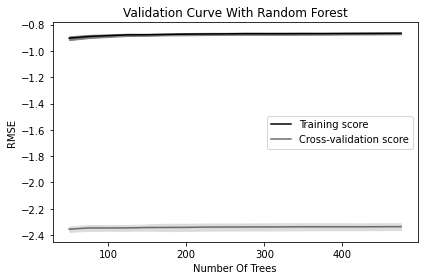

In [55]:
# Create range of values for parameter
param_range = np.arange(50, 500, 25)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestRegressor(random_state=98), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring='neg_root_mean_squared_error', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("RMSE")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Changing the number of trees doesn't seem to make much difference in RMSE. With that in mind, I will choose to use 100 estimators because that is the default parameter.

On to the max number of features per tree.

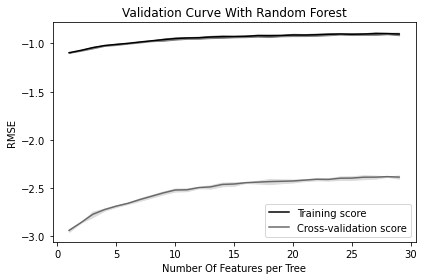

In [56]:
# Create range of values for parameter
param_range = np.arange(1, 30)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestRegressor(random_state=98), 
                                             X_train, 
                                             y_train, 
                                             param_name="max_features", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring='neg_root_mean_squared_error', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Features per Tree")
plt.ylabel("RMSE")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

This parameter is a bit more interesting. We can see that there is a fairly significant change in RMSE with regards to changing the number of features used for making splits! I'll take in the max number of features of 11, as it looks like that's where the elbow starts to bend.

How about adjusting the number of players required to be in each leaf upon making a split?

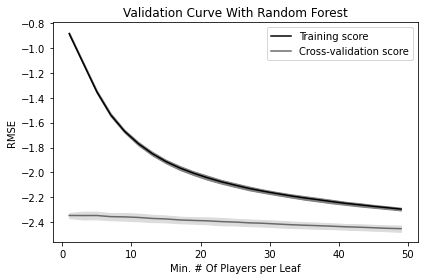

In [57]:
# Create range of values for parameter
param_range = np.arange(1, 50, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestRegressor(random_state=98), 
                                             X_train, 
                                             y_train, 
                                             param_name="min_samples_leaf", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring='neg_root_mean_squared_error', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Min. # Of Players per Leaf")
plt.ylabel("RMSE")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

This is also somewhat interesting, as the default number of 1 has the lowest RMSE by a vast margin. However good that may look, I'm trying to address an issue of overfitting.. and am going to choose a minimum leaf size of 10 because that appears to be where the elbow begins, and the RMSE begins to level off.

Lastly, let's check what changing the max number of splits does for us.

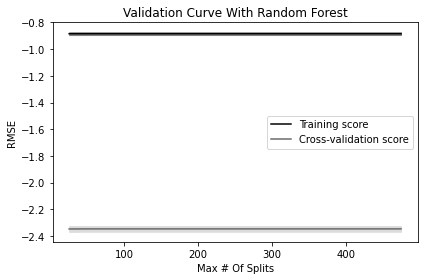

In [58]:
# Create range of values for parameter
param_range = np.arange(0, 500, 25)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestRegressor(random_state=98), 
                                             X_train, 
                                             y_train, 
                                             param_name="max_depth", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring='neg_root_mean_squared_error', 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max # Of Splits")
plt.ylabel("RMSE")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Awesome. It looks like changing the max number of splits allowed doesn't make very much difference in our RMSE. However, I don't want the model to go off the rails and split forever (trying to prevent overfitting), so I'll cap it at 100.

With the last hyperparameter of interest out of the way, I'll go ahead and run a random forest with 100 trees, 11 random features per tree, a minimum leaf size of 10, and a maximum of 100 splits.

In [59]:
RF = RandomForestRegressor(n_estimators=100, max_features=11, min_samples_leaf=10, max_depth=100,
                          random_state=98)

RF_model = RF.fit(X_train, y_train)

In [60]:
# Printing R^2 and RMSE for the KNN Regressor
train_pred = RF_model.predict(X_train)
test_pred = RF_model.predict(X_test)

print(f'Train Set R^2: {RF_model.score(X_train, y_train)}')
print(f'Train Set RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}')
print('\n')
print(f'Test Set R^2: {RF_model.score(X_test, test_pred)}')
print(f'Test Set RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}')

# Random Grid Search Values:
# Train Set R^2: 0.8430859041170221
# Train Set RMSE: 1.4774919544491076

# Test Set R^2: 1.0
# Test Set RMSE: 2.352802294240261

Train Set R^2: 0.7019933495559166
Train Set RMSE: 2.0361375975187914


Test Set R^2: 1.0
Test Set RMSE: 2.526744395925749


Whelp. It looks like after manually tuning, the results got worse on every level. Maybe the Grid Search knew what it was doing after all! Unfortunately, that doesn't help us with our main problem of the test data overfitting to the model. With that in mind, I'll go ahead and use the results from that previous model. 

On the test set, it predicted a player's expected number of seasons left within 2.35 seasons.

I'm pretty sure the issue I got myself into is that, though I added more features, the majority of the new features are derived from the original features that were ran through the model. When I have more time, I would like to run a KMeans Clustering model to identify players by position, and then use that in conjunction with regular season and playoff stats scaled per 36 minutes. Also, I would love to run more data through the models, but have not had time to learn more web-scraping methods that would allow for such niceties.


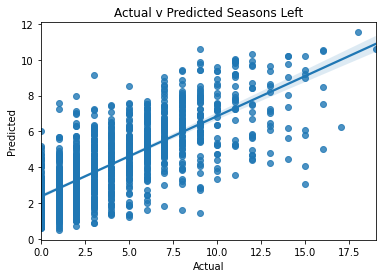

In [67]:
sns.regplot(y_test, test_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual v Predicted Seasons Left')
plt.show()

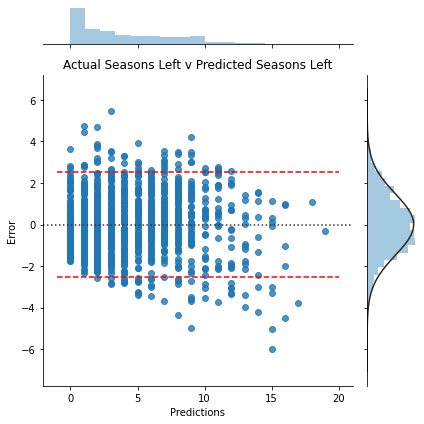

In [239]:
# Doing a jointplot with the residuals of our data to see how far off our estimations are.
sns.jointplot(y_test, test_pred, kind = 'resid')


#Plotting lines that indicate where our RMSE lies.
plt.hlines(np.sqrt(mean_squared_error(y_test, test_pred)), xmin=-1, xmax=20,
          linestyles='dashed', color='red')
plt.hlines(-(np.sqrt(mean_squared_error(y_test, test_pred))), xmin=-1, xmax=20,
          linestyles='dashed', color='red')

plt.xlabel('Predictions')
plt.ylabel('Error')
plt.title('Actual Seasons Left v Predicted Seasons Left')
plt.tight_layout()
plt.show()

# Feature Importances
I just stated above that I introduced probably a few too many redundant features, and looking at the distribution of feature importances shows that. There are only three features (of 147) that explain 5% or more of the variance in seasons left, and they are all relating to a player's age (Age, Season, and Current Year). With more time, I would like to greatly reduce the number of features fed into the model and see if it helps with the observed test set overfitting. 

In [172]:
important_features_dict = {}
for x,i in enumerate(RF_tuned.feature_importances_):
    important_features_dict[list(X.columns)[x]]=i

from itertools import islice

importance_dict = sorted(important_features_dict.items(), key=lambda x: x[1], reverse=True)

In [173]:
def take(n, iterable):
    "Return first n items of the iterable as a dictionary."
    return dict(islice(iterable, n))

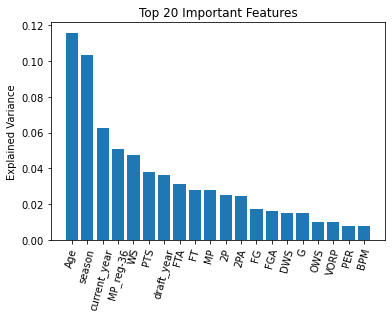

In [174]:
# plot feature importance
plt.bar(take(20, importance_dict).keys(), take(20, importance_dict).values())

plt.xticks(rotation=75)
plt.ylabel('Explained Variance')
plt.title('Top 20 Important Features')
plt.show()

# Predicting Current Players
With the final model in place, let's look and see what it predicts for players that are currently in the NBA. We'll use Dirk Nowitzki and Vince Carter as our means of tracking accuracy, as this data does not have them as being retired yet.

In [96]:
cp_df['season'] = cp_df.current_year - cp_df.draft_year
cp_df = cp_df.loc[cp_df.drafted==1]
cp_df = cp_df.drop(columns = ['Pos', 'Tm'])
cp_df

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,BLK_play-advanced,TOV_play-advanced,PF_play-advanced,PTS_play-advanced,made_playoffs,player_height,player_weight,draft_year,drafted,season
869,Dirk Nowitzki,20.0,47.0,24.0,20.4,2.9,7.1,0.405,0.3,1.4,...,0.0,0.0,0.0,0.0,0,84.0,237.040375,1998.0,1,1.0
932,Vince Carter,22.0,50.0,49.0,35.2,6.9,15.3,0.450,0.4,1.3,...,0.0,0.0,0.0,0.0,0,79.0,215.036627,1998.0,1,1.0
1529,Dirk Nowitzki,21.0,82.0,81.0,35.8,6.3,13.6,0.461,1.4,3.7,...,0.0,0.0,0.0,0.0,0,84.0,237.040375,1998.0,1,2.0
1652,Vince Carter,23.0,82.0,82.0,38.1,9.6,20.7,0.465,1.2,2.9,...,1.2,2.4,3.6,17.5,1,79.0,215.036627,1998.0,1,2.0
1875,Dirk Nowitzki,22.0,82.0,82.0,38.1,7.2,15.2,0.474,1.8,4.8,...,0.7,1.3,3.3,21.1,1,83.0,237.040375,1998.0,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9881,Bam Adebayo,21.0,82.0,28.0,23.3,3.4,5.9,0.576,0.0,0.2,...,0.0,0.0,0.0,0.0,0,82.0,255.043442,2017.0,1,2.0
9882,Steven Adams,25.0,80.0,80.0,33.4,6.0,10.1,0.595,0.0,0.0,...,1.1,2.0,2.9,13.4,1,84.0,265.045145,2013.0,1,6.0
9884,Quincy Acy,28.0,10.0,0.0,12.3,0.4,1.8,0.222,0.2,1.5,...,0.0,0.0,0.0,0.0,0,79.0,240.040886,2012.0,1,7.0
9885,Ryan Anderson,30.0,25.0,8.0,12.9,0.8,2.8,0.304,0.4,1.6,...,0.0,0.0,0.0,0.0,0,82.0,240.040886,2008.0,1,11.0


Going to use our Random Forest Model to make predictions, and then merge them into the dataframe of current players.

In [178]:
pred_cp = RF_tuned.predict(cp_df.drop(columns ='Player'))

ValueError: Number of features of the model must match the input. Model n_features is 147 and input n_features is 148 

In [179]:
# Setting our predictions to a dataframe
pred_cp = pd.DataFrame(pred_cp, columns='predictions')
pred_cp.index = cp_df.index

cp_df = cp_df.merge(pred_cp, left_index=True, right_index=True)
cp_df.rename(columns={0:'predictions'}, inplace=True)

TypeError: Index(...) must be called with a collection of some kind, 'predictions' was passed

In [180]:
cp_df.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,TOV_play-advanced,PF_play-advanced,PTS_play-advanced,made_playoffs,player_height,player_weight,draft_year,drafted,season,0
869,Dirk Nowitzki,20.0,47.0,24.0,20.4,2.9,7.1,0.405,0.3,1.4,...,0.0,0.0,0.0,0,84.0,237.040375,1998.0,1,1.0,7.551691
932,Vince Carter,22.0,50.0,49.0,35.2,6.9,15.3,0.450,0.4,1.3,...,0.0,0.0,0.0,0,79.0,215.036627,1998.0,1,1.0,11.674647
1529,Dirk Nowitzki,21.0,82.0,81.0,35.8,6.3,13.6,0.461,1.4,3.7,...,0.0,0.0,0.0,0,84.0,237.040375,1998.0,1,2.0,10.767939
1652,Vince Carter,23.0,82.0,82.0,38.1,9.6,20.7,0.465,1.2,2.9,...,2.4,3.6,17.5,1,79.0,215.036627,1998.0,1,2.0,11.748256
1875,Dirk Nowitzki,22.0,82.0,82.0,38.1,7.2,15.2,0.474,1.8,4.8,...,1.3,3.3,21.1,1,83.0,237.040375,1998.0,1,3.0,11.584322


In [193]:
cp_df.loc[cp_df.Player == 'Dirk Nowitzki']

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,TOV_play-advanced,PF_play-advanced,PTS_play-advanced,made_playoffs,player_height,player_weight,draft_year,drafted,season,predictions
869,Dirk Nowitzki,20.0,47.0,24.0,20.4,2.9,7.1,0.405,0.3,1.4,...,0.0,0.0,0.0,0,84.0,237.040375,1998.0,1,1.0,7.551691
1529,Dirk Nowitzki,21.0,82.0,81.0,35.8,6.3,13.6,0.461,1.4,3.7,...,0.0,0.0,0.0,0,84.0,237.040375,1998.0,1,2.0,10.767939
1875,Dirk Nowitzki,22.0,82.0,82.0,38.1,7.2,15.2,0.474,1.8,4.8,...,1.3,3.3,21.1,1,83.0,237.040375,1998.0,1,3.0,11.584322
2265,Dirk Nowitzki,23.0,76.0,76.0,38.0,7.9,16.6,0.477,1.8,4.6,...,2.2,2.7,22.9,1,84.0,245.041738,1998.0,1,4.0,11.289934
2803,Dirk Nowitzki,24.0,80.0,80.0,39.0,8.6,18.6,0.463,1.9,4.9,...,2.0,2.6,21.4,1,84.0,245.041738,1998.0,1,5.0,11.307587
3212,Dirk Nowitzki,25.0,77.0,77.0,37.9,7.9,17.0,0.462,1.3,3.8,...,1.0,2.7,22.6,1,84.0,245.041738,1998.0,1,6.0,10.073436
3488,Dirk Nowitzki,26.0,78.0,78.0,38.7,8.5,18.5,0.459,1.2,2.9,...,2.2,2.7,20.1,1,84.0,245.041738,1998.0,1,7.0,9.296281
4048,Dirk Nowitzki,27.0,81.0,81.0,38.1,9.3,19.3,0.480,1.4,3.3,...,1.8,2.3,22.7,1,84.0,245.041738,1998.0,1,8.0,8.653703
4229,Dirk Nowitzki,28.0,78.0,78.0,36.2,8.6,17.2,0.502,0.9,2.2,...,2.1,3.0,17.8,1,84.0,245.041738,1998.0,1,9.0,8.139548
4946,Dirk Nowitzki,29.0,77.0,77.0,36.0,8.2,17.1,0.479,1.0,2.9,...,1.7,2.2,22.9,1,84.0,245.041738,1998.0,1,10.0,7.523214


In [194]:
cp_df.loc[cp_df.Player == 'Vince Carter']

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,TOV_play-advanced,PF_play-advanced,PTS_play-advanced,made_playoffs,player_height,player_weight,draft_year,drafted,season,predictions
932,Vince Carter,22.0,50.0,49.0,35.2,6.9,15.3,0.450,0.4,1.3,...,0.0,0.0,0.0,0,79.0,215.036627,1998.0,1,1.0,11.674647
1652,Vince Carter,23.0,82.0,82.0,38.1,9.6,20.7,0.465,1.2,2.9,...,2.4,3.6,17.5,1,79.0,215.036627,1998.0,1,2.0,11.748256
2056,Vince Carter,24.0,75.0,75.0,39.7,10.2,22.1,0.460,2.2,5.3,...,1.8,3.0,21.8,1,78.0,225.038331,1998.0,1,3.0,11.508469
2468,Vince Carter,25.0,60.0,60.0,39.8,9.3,21.8,0.428,2.0,5.2,...,0.0,0.0,0.0,0,78.0,225.038331,1998.0,1,4.0,9.087866
2608,Vince Carter,26.0,43.0,42.0,34.2,8.3,17.7,0.467,1.0,3.0,...,0.0,0.0,0.0,0,78.0,225.038331,1998.0,1,5.0,8.089663
3152,Vince Carter,27.0,73.0,73.0,38.2,8.3,20.0,0.417,1.3,3.3,...,0.0,0.0,0.0,0,78.0,225.038331,1998.0,1,6.0,7.262466
3704,Vince Carter,28.0,77.0,76.0,36.7,9.0,20.0,0.452,1.6,4.1,...,3.0,3.4,21.5,1,78.0,220.037479,1998.0,1,7.0,7.621870
3897,Vince Carter,29.0,79.0,79.0,36.8,8.3,19.2,0.430,1.6,4.6,...,2.1,2.7,26.1,1,78.0,220.037479,1998.0,1,8.0,8.323750
4213,Vince Carter,30.0,82.0,82.0,38.1,8.9,19.5,0.454,1.9,5.3,...,2.8,2.6,19.8,1,78.0,220.037479,1998.0,1,9.0,6.881523
4882,Vince Carter,31.0,76.0,72.0,38.9,7.7,16.9,0.456,1.3,3.6,...,0.0,0.0,0.0,0,78.0,220.037479,1998.0,1,10.0,5.742163


In [195]:
cp_df.loc[cp_df.Player == 'LeBron James']

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,TOV_play-advanced,PF_play-advanced,PTS_play-advanced,made_playoffs,player_height,player_weight,draft_year,drafted,season,predictions
3133,LeBron James,19.0,79.0,79.0,39.5,7.9,18.9,0.417,0.8,2.7,...,0.0,0.0,0.0,0,80.0,240.040886,2003.0,1,1.0,10.312938
3567,LeBron James,20.0,80.0,80.0,42.4,9.9,21.1,0.472,1.4,3.9,...,0.0,0.0,0.0,0,80.0,240.040886,2003.0,1,2.0,10.268127
3947,LeBron James,21.0,79.0,79.0,42.5,11.1,23.1,0.480,1.6,4.8,...,3.9,2.6,23.8,1,80.0,240.040886,2003.0,1,3.0,10.910602
4612,LeBron James,22.0,78.0,78.0,40.9,9.9,20.8,0.476,1.3,4.0,...,2.7,1.6,20.2,1,80.0,240.040886,2003.0,1,4.0,10.566464
4748,LeBron James,23.0,75.0,74.0,40.4,10.6,21.9,0.484,1.5,4.8,...,3.5,2.2,23.9,1,80.0,250.042590,2003.0,1,5.0,9.806999
5129,LeBron James,24.0,81.0,81.0,37.7,9.7,19.9,0.489,1.6,4.7,...,2.4,1.9,30.7,1,80.0,250.042590,2003.0,1,6.0,9.501809
5638,LeBron James,25.0,76.0,76.0,39.0,10.1,20.1,0.503,1.7,5.1,...,3.3,1.8,25.0,1,80.0,250.042590,2003.0,1,7.0,8.467028
6090,LeBron James,26.0,79.0,79.0,38.8,9.6,18.8,0.510,1.2,3.5,...,2.6,2.2,19.4,1,80.0,250.042590,2003.0,1,8.0,8.255337
6569,LeBron James,27.0,62.0,62.0,37.5,10.0,18.9,0.531,0.9,2.4,...,3.0,1.7,25.5,1,80.0,250.042590,2003.0,1,9.0,7.193328
6984,LeBron James,28.0,76.0,76.0,37.9,10.1,17.8,0.565,1.4,3.3,...,2.6,1.6,22.3,1,80.0,250.042590,2003.0,1,10.0,7.061379


In [228]:
def scatter_seasons(player):
    """Takes in a current NBA player's name, and returns a scatter plot of their current year in
    the NBA and the model's prediction for how many more years they have left.
    """
    sns.scatterplot(x='season', y='predictions', data=cp_df.loc[cp_df.Player == f'{player}'])
    plt.title(f'Seasons Played v Predicted for {player}')
    plt.xlabel('Current Season in NBA')
    plt.ylabel('Predicted Seasons Left ')
    plt.tight_layout()
    plt.show()
    return

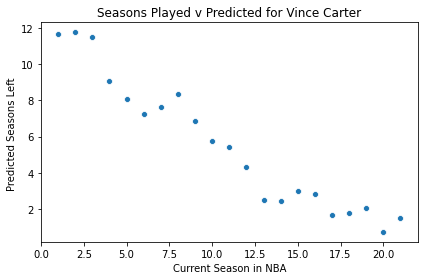

In [229]:
scatter_seasons('Vince Carter')

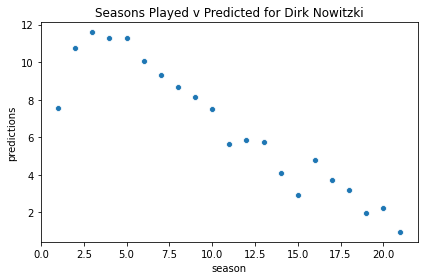

In [224]:
scatter_seasons('Dirk Nowitzki')

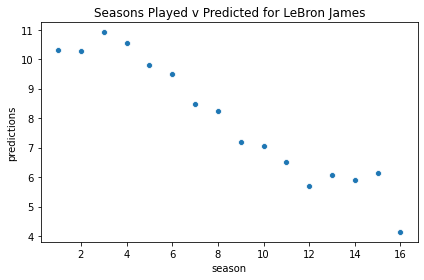

In [226]:
scatter_seasons('LeBron James')

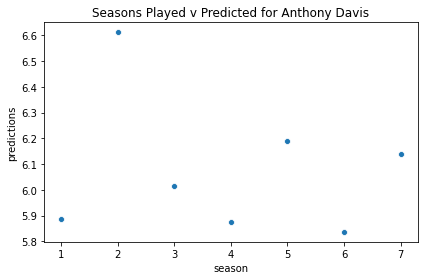

In [227]:
scatter_seasons('Anthony Davis')

In [230]:
96/568

0.16901408450704225

In [231]:
150/568

0.2640845070422535

In [236]:
len(df.current_year.value_counts())

22

In [243]:
30*15

450

In [246]:
1-(2.5/15)

0.8333333333333334

In [247]:
X_train.shape

(4813, 147)

In [248]:
cp_df[['season', 'current_year']]

,season,current_year
869,1.0,1999
932,1.0,1999
1529,2.0,2000
1652,2.0,2000
1875,3.0,2001
...,...,...
9881,2.0,2019
9882,6.0,2019
9884,7.0,2019
9885,11.0,2019
